In [0]:
#@title    import drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
  %tensorflow_version 1.14
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


In [0]:
#@title generator
#generator.py

import cv2
import numpy as np

from keras.preprocessing.image import img_to_array


def category_label(labels, dims, n_labels):
    x = np.zeros([dims[0], dims[1], n_labels])
    #print(labels)
    for i in range(dims[0]):
        for j in range(dims[1]):
          x[i, j, (int)(labels[i][j]/255)] = 1
    x = x.reshape(dims[0] * dims[1], n_labels)
    return x


def data_gen_small(img_dir, mask_dir, lists, batch_size, dims, n_labels):
    while True:
        ix = np.random.choice(np.arange(len(lists)), batch_size)
        imgs = []
        labels = []
        for i in ix:
            # images
            img_path = img_dir + lists.iloc[i, 0] + '.tif'
#            print( img_path )
            original_img = cv2.imread(img_path)[:, :, ::-1]
            resized_img = cv2.resize(original_img, (dims[0], dims[1]))
            array_img = img_to_array(resized_img)
#            print(array_img.size)
            imgs.append(array_img)
            # masks
            original_mask = cv2.imread(mask_dir + lists.iloc[i, 0] + '.tif')
            resized_mask = cv2.resize(original_mask, (dims[0], dims[1]))
#            print(resized_mask.shape)
            array_mask = category_label(resized_mask[:, :, 0], dims, n_labels)
            labels.append(array_mask)
        imgs = np.array(imgs)
        labels = np.array(labels)
        yield imgs, labels

In [0]:
#@title   layers
#layers.py

from tensorflow.keras import backend as K
from keras.layers import Layer


class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                        input_shape[0],
                        input_shape[1]*self.size[0],
                        input_shape[2]*self.size[1],
                        input_shape[3])
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype='int32')
            batch_shape = K.concatenate(
                    [[input_shape[0]], [1], [1], [1]],
                    axis=0)
            batch_range = K.reshape(
                    tf.range(output_shape[0], dtype='int32'),
                    shape=batch_shape)
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = tf.range(output_shape[3], dtype='int32')
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = tf.size(updates)
            indices = K.transpose(K.reshape(
                K.stack([b, y, x, f]),
                [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )


In [0]:
#@title   training
#train.py


import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras
from keras.models import load_model


#from  model import segnet
#from generator import data_gen_small


def main():
    # set the necessary list
    train_list = pd.read_csv("/content/drive/My Drive/sarseg/Data/complete_dataset/crop/noisy_list.csv", header=None)
    val_list = pd.read_csv("/content/drive/My Drive/sarseg/Data/complete_dataset/crop/noisy_list.csv", header=None)

    # set the necessary directories
    trainimg_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/crop/noisy images/"
    trainmsk_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/crop/gt/"
    valimg_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/crop/noisy images/"
    valmsk_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/crop/gt/"

    train_gen = data_gen_small(trainimg_dir, trainmsk_dir,
            train_list, 8,
            [512, 512], 2)
    val_gen = data_gen_small(valimg_dir, valmsk_dir,
            val_list, 8,
            [512, 512], 2)

    model = keras.models.load_model('/content/drive/My Drive/sarseg/Data/modelout/sar6.h5',
                                     custom_objects={'MaxPoolingWithArgmax2D': MaxPoolingWithArgmax2D, 'MaxUnpooling2D':MaxUnpooling2D})
    model.load_weights('/content/drive/My Drive/sarseg/Data/modelout/sar6.hdf5')
#   print(model.summary())

    model.compile(loss="categorical_crossentropy",
            optimizer="adadelta", metrics=["accuracy"])
    model.fit_generator(train_gen, steps_per_epoch=8,
            epochs=8, validation_data=val_gen,
            validation_steps=8)

    model.save_weights("/content/drive/My Drive/sarseg/Data/modelout/"+"sar7"+".hdf5")
    model.save("/content/drive/My Drive/sarseg/Data/modelout/"+"sar7"+".h5")
    print("save weight done..")


if __name__ == "__main__":
    main()


Epoch 1/8
8/8 [==============================] - 950s 119s/step - loss: 0.1035 - accuracy: 0.9697 - val_loss: 0.1655 - val_accuracy: 0.9367
Epoch 2/8
8/8 [==============================] - 872s 109s/step - loss: 0.0884 - accuracy: 0.9780 - val_loss: 0.1077 - val_accuracy: 0.9504
Epoch 3/8
8/8 [==============================] - 877s 110s/step - loss: 0.0894 - accuracy: 0.9759 - val_loss: 0.1949 - val_accuracy: 0.9325
Epoch 4/8
8/8 [==============================] - 874s 109s/step - loss: 0.0881 - accuracy: 0.9760 - val_loss: 0.1121 - val_accuracy: 0.9481
Epoch 5/8
8/8 [==============================] - 874s 109s/step - loss: 0.0893 - accuracy: 0.9759 - val_loss: 0.0944 - val_accuracy: 0.9543
Epoch 6/8
8/8 [==============================] - 880s 110s/step - loss: 0.0766 - accuracy: 0.9789 - val_loss: 0.0975 - val_accuracy: 0.9445
Epoch 7/8
8/8 [==============================] - 878s 110s/step - loss: 0.0733 - accuracy: 0.9809 - val_loss: 0.1406 - val_accuracy: 0.9482
Epoch 8/8
8/8 [=====

In [0]:
#@title   loading model

import keras
import pandas as pd
import tensorflow as tf

from keras.models import load_model
model_test = keras.models.load_model('/content/drive/My Drive/sarseg/Data/modelout/sar6.h5',
                                     custom_objects={'MaxPoolingWithArgmax2D': MaxPoolingWithArgmax2D, 'MaxUnpooling2D':MaxUnpooling2D})
#model_test = segnet((512, 512 ,3), 2,
#          3, (2, 2), "softmax")
model_test.load_weights('/content/drive/My Drive/sarseg/Data/modelout/sar6.hdf5')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [0]:
#@title   getting loaded model accuracy


val_list = pd.read_csv("/content/drive/My Drive/sarseg/Data/complete_dataset/crop/val_list.csv", header=None)

valimg_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/crop/images/"
valmsk_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/crop/gt/"

val_gen = data_gen_small(valimg_dir, valmsk_dir,
             val_list, 1,
            [512, 512], 2)

model_test.compile(loss="categorical_crossentropy",
            optimizer="adadelta", metrics=["accuracy"])
score = model_test.evaluate(val_gen, steps = 1)
print("%s: %.2f%%" % (model_test.metrics_names[1], score[1]*100))

In [0]:
#@title predicting output

valimg_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/"
valmsk_dir = "/content/drive/My Drive/sarseg/Data/complete_dataset/"

test = np.zeros([1, 512, 512, 3])
test_image = cv2.imread(valimg_dir + 'SAR6.jpg')
tested = cv2.resize(test_image, (512, 512))
test[0] = img_to_array(tested)

mask = np.zeros([1, 512, 512, 3])
test_image = cv2.imread(valmsk_dir + 'SAR6.jpg')
tested = cv2.resize(test_image, (512, 512))
array_mask = category_label(tested[:, :, 0], (512, 512, 3), 2)

predicted_out = model_test.predict(test)

In [0]:
print(predicted_out)
print(array_mask)

[[[0.95681393 0.04318608]
  [0.96705586 0.03294409]
  [0.9691658  0.03083421]
  ...
  [0.9591624  0.04083755]
  [0.958903   0.04109699]
  [0.9501279  0.0498721 ]]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [0]:
#@title   making image arrays for matplot

array_mask.shape
mask = np.zeros([512, 512])
for i in range(512):
  for j in range(512):
    mask[i][j] = array_mask[i*512+j][0];

predicted = predicted_out[0]
predicted.shape
pred = np.zeros([512, 512])
for i in range(512):
  for j in range(512):
    if(predicted[i*512+j][0] > 0.90):
      pred[i][j] = 1;
    else:
      pred[i][j] = 0;  


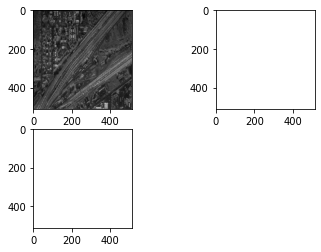

In [0]:
#@title   plotting images

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(test[0].astype(int))
ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(mask, cmap= 'Greys')
ax3 = fig.add_subplot(2, 2, 3)
ax3.imshow(pred, cmap= 'Greys')

In [0]:
#@title   printing custom prediction accuracy

from keras import backend as K
total = 512*512
intersection = 0
for i in range(512):
  for j in range(512):
    if( mask[i][j] == pred[i][j] ):
        intersection = intersection + 1 
    
print(intersection/total)

0.8409233093261719
